In [1]:
#import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
import pprint
import time
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Modeling

Jupyter Notebook only focused on performance of the models. The notebook is divided into 4 parts:

- Feature engineering & selection
- Model selection
- Model evaluation
- Model comparison

## Feature Engineering & Selection


In [2]:
# import data

df = pd.read_csv('AB_NYC_2019.csv')

In [4]:
def feature_engineering(df, outliers:bool = False,outliers_method:str =None, scaling:bool = False, scaling_method:str = None):

    """
    Assert that the NaN values for last_review and reviews_per_month columns have the same ID
    It is logical: if a rent never had a review i.e last_review = NaN then reviews_per_month is NaN too
    Therefore NaN will be replaced by 0, and only one column (reviews_per_month) will be kept
    """
    np.any(df.loc[df['last_review'].isnull(), 'last_review'].index == df.loc[df['reviews_per_month'].isnull(), 'reviews_per_month'].index)

    cols_to_drop = ['name', 'host_name', 'last_review', 'id', 'longitude', 'latitude'] # columns to drop, first model run with host_id

    df.drop(cols_to_drop, axis=1, inplace=True)

    # replace NaN values by 0 in reviews_per_month column
    df['reviews_per_month'].fillna(0, inplace=True)
    # one hot encoding of neighbourhood_group column
    df = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type'], drop_first=True)

    # drop outliers
    # get all numerical columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns

    if outliers:
        if outliers_method == 'zscore':
            z = np.abs(stats.zscore(df[num_cols]))
            df = df[(z < 3).all(axis=1)]

        elif outliers_method == 'iqr':
            q1 = df[num_cols].quantile(0.25)
            q3 = df[num_cols].quantile(0.75)
            iqr = q3 - q1
            df = df[~((df[num_cols] < (q1 - 1.5 * iqr)) | (df[num_cols] > (q3 + 1.5 * iqr))).any(axis=1)]

        else:
            print('Invalid outliers method')
            return


    # split data into train and test sets

    X = df.drop('price', axis=1)
    y = df['price']

    cols = X.columns

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # target encode neighbourhood and host_id columns

    # neighbourhood
    import category_encoders as ce
    encoder = ce.TargetEncoder(cols=['neighbourhood'])
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test)

    # host_id
    encoder = ce.TargetEncoder(cols=['host_id'])
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test)

    # scale the data 

    if scaling:
        if scaling_method == 'standard':
            scaler = StandardScaler()
        elif scaling_method == 'minmax':
            scaler = MinMaxScaler()
        elif scaling_method == 'robust':
            scaler = RobustScaler()
        else:
            print('Invalid scaling method')
            return

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, cols



In [5]:
X_train, X_test, y_train, y_test, colname = feature_engineering(df, outliers=True, outliers_method='zscore', scaling=True, scaling_method='standard')

In [6]:
# print shapes of train and test sets

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36512, 13) (9128, 13) (36512,) (9128,)


In [8]:
# choix des models
def preprocessing(X_train, X_test, y_train, y_test):  
    models = {'Decision Tree Regressor' : DecisionTreeRegressor(random_state=42),
          'Bagging Regressor' : BaggingRegressor(random_state=42, base_estimator=DecisionTreeRegressor(random_state=42)),
          'AdaBoost Regressor' : AdaBoostRegressor(random_state=42, base_estimator=DecisionTreeRegressor(random_state=42)),
          'RandomForestRegressor' :RandomForestRegressor(random_state=42, n_jobs=-1), 
          'ExtraTreesRegressor' : ExtraTreesRegressor(random_state=42, n_jobs=-1),
          'GradientBoostingRegressor' : GradientBoostingRegressor(random_state=42),
          'XGBoostRegressor' : xgb.XGBRegressor( objective ='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', gpu_id=0, random_state=42),
          'LightGBMRegressor' : LGBMRegressor(random_state=42, n_jobs=-1),
          'CatBoostRegressor' : CatBoostRegressor(random_state=42, silent=True, task_type='GPU', devices='0:1')}

    results = []
    for model_name, model in models.items():
        start = time.time()
        # cross-validation
        cross_val = cross_val_score(model, X_train, y_train, cv=5)
        # model fitting and prediction
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # calculating metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        # saving results in a list
        results.append([model_name, cross_val.mean(), mse, rmse, mae, r2])
        end = time.time()
        print(f'{model_name} done !')
        print(f'Time taken: {end-start:.2f} seconds')
        print('--------------------------------------')

    # creating a DataFrame with the results
    df = pd.DataFrame(results, columns=['Model', 'Cross-Val Score', 'MSE', 'RMSE', 'MAE', 'R2'])
    # sorting by best R2 and RMSE scores
    df = df.sort_values(by=['R2', 'RMSE'], ascending=[False, True])
    # resetting the index
    df.reset_index(drop=True, inplace=True)
    return df

In [9]:
df_models = preprocessing(X_train, X_test, y_train, y_test)

Decision Tree Regressor done !
Time taken: 1.02 seconds
--------------------------------------
Bagging Regressor done !
Time taken: 8.88 seconds
--------------------------------------
AdaBoost Regressor done !
Time taken: 14.65 seconds
--------------------------------------
RandomForestRegressor done !
Time taken: 13.46 seconds
--------------------------------------
ExtraTreesRegressor done !
Time taken: 8.44 seconds
--------------------------------------
GradientBoostingRegressor done !
Time taken: 13.20 seconds
--------------------------------------
XGBoostRegressor done !
Time taken: 2.38 seconds
--------------------------------------
LightGBMRegressor done !
Time taken: 0.83 seconds
--------------------------------------
CatBoostRegressor done !
Time taken: 78.49 seconds
--------------------------------------


In [10]:
df_models

,Model,Cross-Val Score,MSE,RMSE,MAE,R2
0,LightGBMRegressor,0.533647,6127.312891,78.277154,46.593508,0.469632
1,CatBoostRegressor,0.532240,6137.923435,78.344901,46.597488,0.468714
2,XGBoostRegressor,0.508138,6258.826514,79.112746,47.205453,0.458249
3,GradientBoostingRegressor,0.517415,6278.812094,79.238956,47.369129,0.456519
4,RandomForestRegressor,0.480165,6637.473894,81.470693,48.681956,0.425474
5,ExtraTreesRegressor,0.439226,7061.502177,84.032745,49.945992,0.388771
6,Bagging Regressor,0.441996,7080.116394,84.143428,50.209205,0.387159
7,AdaBoost Regressor,0.381600,7859.497438,88.653807,51.190560,0.319698
8,Decision Tree Regressor,0.059061,11562.789282,107.530411,62.650639,-0.000852


Let's focus on the model tuning on our 3models :
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost



In [33]:
def DT_tuning(X_train, X_test, y_train, y_test):
    # define the grid of values for max_depth and min_samples_leaf
    param_grid = {'max_depth': [3, 5, 7],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 2, 3]}

    # instantiate a DecisionTreeRegressor
    dt = DecisionTreeRegressor(random_state=42)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # instantiate the GridSearchCV object and run the search
    dt_cv = GridSearchCV(dt, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    dt_cv.fit(X_train, y_train)
    # print the optimal parameters and best score
    print("Tuned Decision Tree Parameters: {}".format(dt_cv.best_params_)) 
    print("Best score is {}".format(dt_cv.best_score_))
    print("Best estimator is {}".format(dt_cv.best_estimator_))

    print('-------------------------------------------------')
    # instantiate a DecisionTreeRegressor with the optimal parameters
    dt_tuned = DecisionTreeRegressor(random_state=42, **dt_cv.best_params_)

    # fit dt_tuned to the training set
    dt_tuned.fit(X_train, y_train)

    # predict test set labels
    y_pred = dt_tuned.predict(X_test)

    # compute mse_dt
    mse_dt = mean_squared_error(y_test, y_pred)

    # compute rmse_dt
    rmse_dt = np.sqrt(mse_dt)

    # compute mae_dt
    mae_dt = mean_absolute_error(y_test, y_pred)

    # compute r2_dt

    r2_dt = r2_score(y_test, y_pred)

    df_results = pd.DataFrame({'Model': ['Decision Tree Regressor'], 'Cross-Val Score': [dt_cv.best_score_], 'MSE': [mse_dt], 'RMSE': [rmse_dt], 'MAE': [mae_dt], 'R2': [r2_dt]})
    
    # show the results
    
    #use pprint to print the results in a nice format

    pp = pprint.PrettyPrinter()  # set the indentation level to 4
    pp.pprint(df_results)


    print('-------------------------------------------------')
    
    #plot regression

    plt.figure(figsize=(20,10))
    sns.regplot(x=y_test, y=y_pred)
    plt.title(f'Decision Tree Regressor, R2 = {np.round(r2_dt,2)}')
    plt.show()

    print('-------------------------------------------------')

    print('Decision Tree Regressor: finished')


    return df_results

Tuned Decision Tree Parameters: {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best score is -6009.3936059294865
Best estimator is DecisionTreeRegressor(max_depth=7, min_samples_leaf=3, random_state=42)
-------------------------------------------------
                     Model  Cross-Val Score          MSE       RMSE  \
0  Decision Tree Regressor     -6009.393606  6716.155689  81.952155   

         MAE        R2  
0  49.041747  0.418663  
-------------------------------------------------


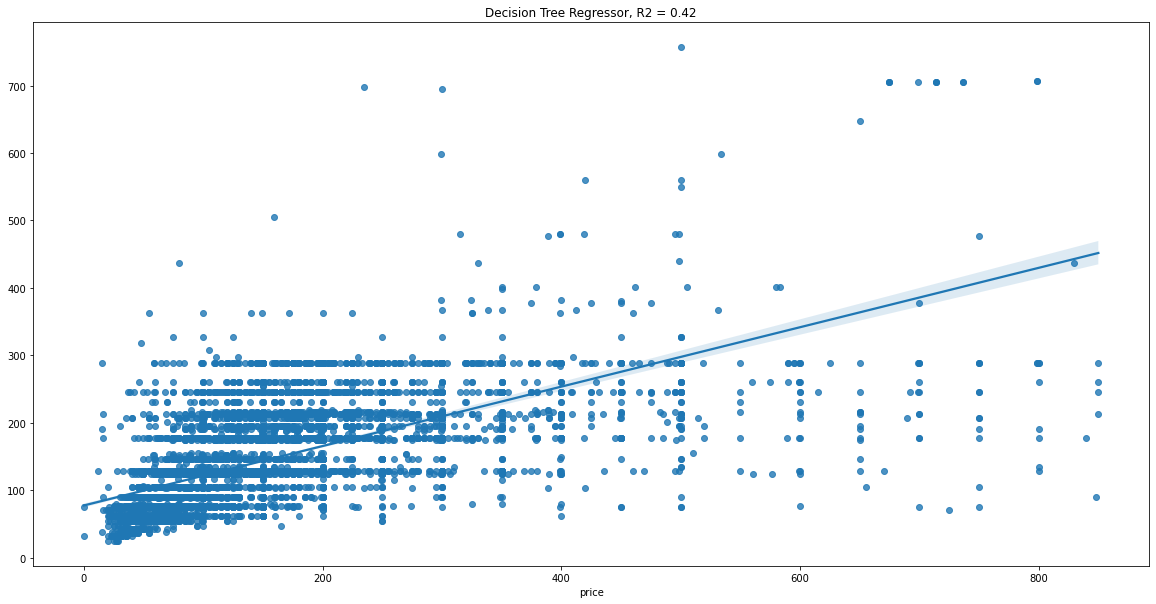

-------------------------------------------------
Decision Tree Regressor: finished


In [34]:
df_DT = DT_tuning(X_train, X_test, y_train, y_test)

In [35]:
df_DT

,Model,Cross-Val Score,MSE,RMSE,MAE,R2
0,Decision Tree Regressor,-6009.393606,6716.155689,81.952155,49.041747,0.418663


In [65]:
def RF_tuning():
    # Grid Search
    # choix des hyperparamètres à tester pour le modèle RandomForestRegressor    
    param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 7, 9, None],
    # 'min_samples_split': [2, 4, 6],
    # 'min_samples_leaf': [1, 2, 3],
    'max_samples' : [0.5, 0.75, 1]
    }

    # cross validation avec 5 folds et mélange des données à chaque itération
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # création du modèle
    rf_model = RandomForestRegressor(random_state=42)


    start = time.time()

    # initialisation de la Grid Search avec les hyperparamètres à tester, le modèle et le nombre de folds
    grid_search = GridSearchCV(rf_model, param_grid, cv=cv, n_jobs=-1, verbose=1)

    grid_search.fit(X_train, y_train)

    print(f'Best params: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')

    end = time.time()

    print(f'Grid Search took {end - start} seconds')

    print('Grid Search fini !')

    print('---------')

    rf = RandomForestRegressor(random_state=42,**grid_search.best_params_)
    
    model_test = rf.fit(X_train, y_train)
        
    y_pred = model_test.predict(X_test)

    # compute mse_dt
    mse_rf = mean_squared_error(y_test, y_pred)

    # compute rmse_dt
    rmse_rf = np.sqrt(mse_rf)

    # compute mae_dt

    mae_rf = mean_absolute_error(y_test, y_pred)

    # compute r2_dt

    r2_rf = r2_score(y_test, y_pred)

    df_results = pd.DataFrame({'Model': ['Random Forest Regressor'], 'Cross-Val Score': [grid_search.best_score_], 'MSE': [mse_rf], 'RMSE': [rmse_rf], 'MAE': [mae_rf], 'R2': [r2_rf]})

    # show the results

    #use pprint to print the results in a nice format

    pp = pprint.PrettyPrinter()  # set the indentation level to 4
    pp.pprint(df_results)

    print('-------------------------------------------------')

    #plot feature importance 

    feature_importance = pd.DataFrame({'feature': colname, 'importance': model_test.feature_importances_})
    feature_importance.sort_values('importance', ascending=False, inplace=True)
    feature_importance.reset_index(drop=True, inplace=True)

    # plot
    plt.figure(figsize=(10, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance.iloc[:20])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    print('-------------------------------------------------')

    #plot regression

    plt.figure(figsize=(10,10))
    sns.regplot(x=y_test, y=y_pred)
    plt.title(f'Random Forest Regressor, R2 = {np.round(r2_rf,2)}')

    plt.show()

    print('-------------------------------------------------')

    print('Random Forest Regressor: finished')

    return df_results

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best params: {'max_depth': 9, 'max_samples': 0.5, 'n_estimators': 200}
Best score: 0.5194540147126643
Grid Search took 109.08505630493164 seconds
Grid Search fini !
---------
                     Model  Cross-Val Score          MSE       RMSE  \
0  Random Forest Regressor         0.519454  6270.509146  79.186546   

         MAE        R2  
0  47.025017  0.457237  
-------------------------------------------------


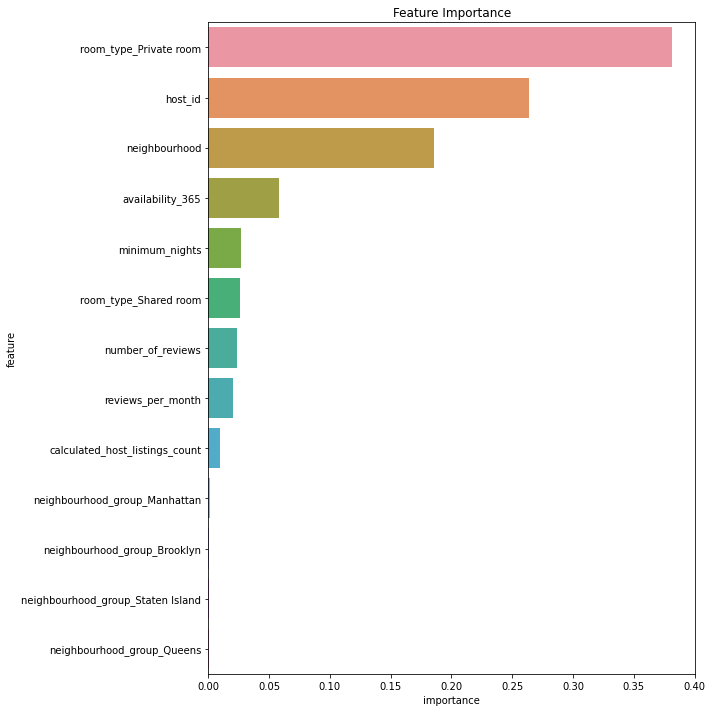

-------------------------------------------------


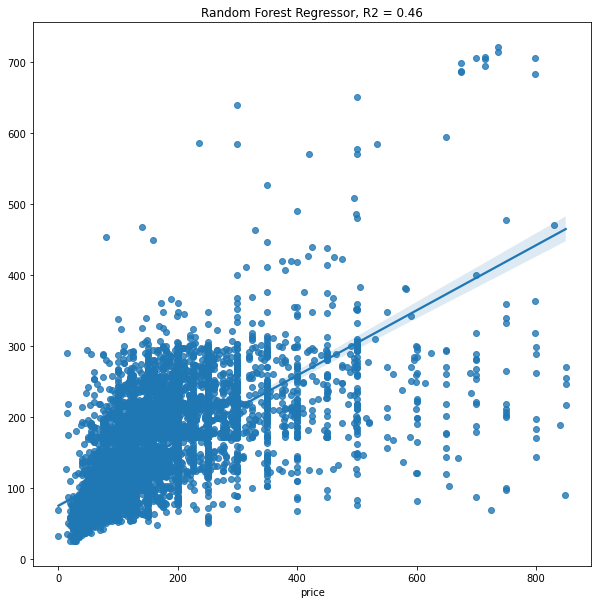

-------------------------------------------------
Random Forest Regressor: finished


In [66]:
df_RF = RF_tuning()

In [67]:
df_RF

,Model,Cross-Val Score,MSE,RMSE,MAE,R2
0,Random Forest Regressor,0.519454,6270.509146,79.186546,47.025017,0.457237


In [42]:
def XGBoost_tuning():
    param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    # 'subsample': [0.5, 0.75, 1],
    # 'colsample_bytree': [0.5, 0.75, 1]
    }

    # cross validation avec 5 folds et mélange des données à chaque itération
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # création du modèle
    xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', random_state=42)
    
    start = time.time() # début du chronomètre

    # initialisation de la Grid Search avec les hyperparamètres à tester, le modèle et le nombre de folds
    grid_search = GridSearchCV(xgb_model, param_grid, cv=cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    #print the best parameters
    print(f'Best params: {grid_search.best_params_}')

    #print the best score
    print(f'Best score: {grid_search.best_score_}')

    end = time.time() # fin du chronomètre

    print(f'Grid Search took {end - start} seconds')

    print('Grid Search fini !')

    print('---------')

    xgtrain = xgb.DMatrix(X_train, label=y_train)
    xgtest = xgb.DMatrix(X_test, label=y_test)

    gbr =  xgb.XGBRegressor( objective ='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', random_state=42, **grid_search.best_params_)

    model_test = xgb.train(gbr.get_xgb_params(), xgtrain, num_boost_round=1000, early_stopping_rounds=10, evals=[(xgtest, 'test')], verbose_eval=False)

    y_pred = model_test.predict(xgtest)

    # compute mse_dt
    mse_xgb = mean_squared_error(y_test, y_pred)

    # compute rmse_dt
    rmse_xgb = np.sqrt(mse_xgb)

    # compute mae_dt

    mae_xgb = mean_absolute_error(y_test, y_pred)

    # compute r2_dt

    r2_xgb = r2_score(y_test, y_pred)

    df_results = pd.DataFrame({'Model': ['XGBoost'], 'Cross-Val Score': [grid_search.best_score_], 'MSE': [mse_xgb], 'RMSE': [rmse_xgb], 'MAE': [mae_xgb], 'R2': [r2_xgb]})

    # show the results
    #use pprint to print the results in a nice format

    pp = pprint.PrettyPrinter()  # set the indentation level to 4
    pp.pprint(df_results)

    print('-------------------------------------------------')

    #plot feature importance
    # plt.figure(figsize=(10,10))

    #xgb.plot_importance(model_test, max_num_features=10, importance_type='gain')    
    # plt.show()

    #plot feature importance 

    # get feature importance
    importance = model_test.get_score(importance_type='gain')

    # create a list of tuples with feature name and importance score
    feature_importance = [(colname[int(k[1:])], v) for k, v in importance.items()]


    # create dataframe from the list of tuples
    feature_importance_df = pd.DataFrame(feature_importance, columns=['feature', 'importance'])
    feature_importance_df.sort_values('importance', ascending=False, inplace=True)

    # plot feature importance
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(x='importance', y='feature', data=feature_importance_df.iloc[:10])
    ax.set_yticks(range(len(feature_importance_df)))
    ax.set_yticklabels(feature_importance_df['feature'])
    plt.show()

    print('-------------------------------------------------')

    #plot regression

    plt.figure(figsize=(10,10))
    sns.regplot(x=y_test, y=y_pred)
    plt.title(f'XGBoost, R2 = {np.round(r2_xgb,2)}')

    plt.show()

    print('-------------------------------------------------')

    print('XGBoost: finished')

    return df_results   
    

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best score: 0.5314992786976944
Grid Search took 77.538809299469 seconds
Grid Search fini !
---------
     Model  Cross-Val Score          MSE       RMSE        MAE        R2
0  XGBoost         0.531499  6132.497623  78.310265  46.617095  0.469183
-------------------------------------------------


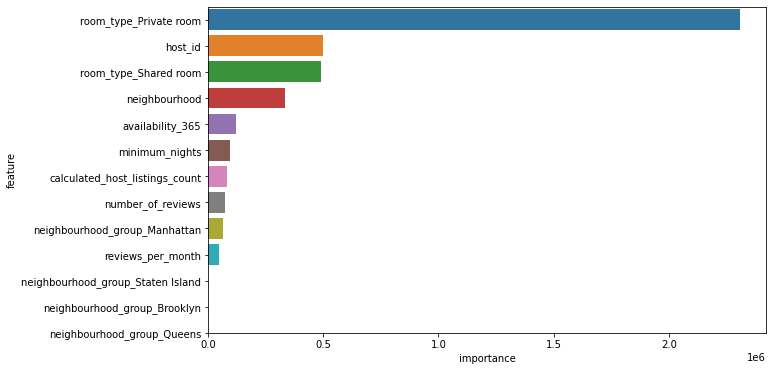

-------------------------------------------------


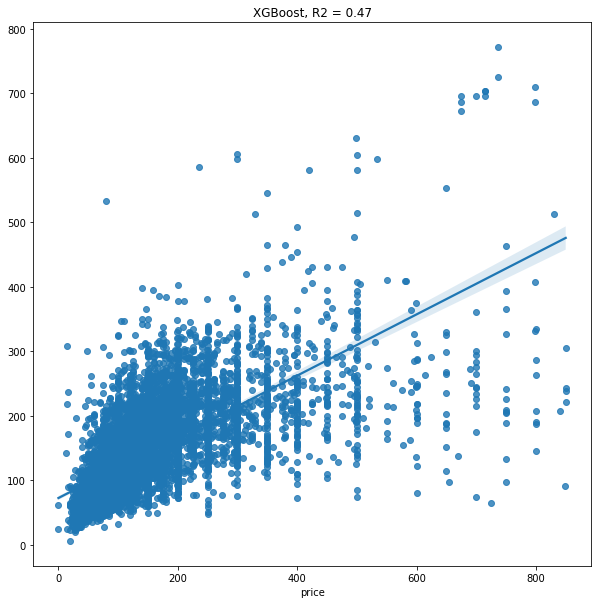

-------------------------------------------------
XGBoost: finished


In [43]:
df_XGB = XGBoost_tuning()

In [64]:
df_XGB

,Model,Cross-Val Score,MSE,RMSE,MAE,R2
0,XGBoost,0.531499,6132.497623,78.310265,46.617095,0.469183


In [79]:
#join the results of the three tuned models in a single dataframe

df_results = pd.concat([df_DT, df_RF, df_XGB], ignore_index=True)

#change the name of the models to add "_tuned" at the end

df_results['Model'] = df_results['Model'].apply(lambda x: x + '_tuned')

# join the results of the three tuned models with the results of the untuned models

df_final_results = pd.concat([df_results, df_models], ignore_index=True)

df_final_results = df_final_results.sort_values(by=['R2', 'RMSE'], ascending=[False, True])

df_final_results

,Model,Cross-Val Score,MSE,RMSE,MAE,R2
2,XGBoost_tuned,0.531499,6132.497623,78.310265,46.617095,0.469183
3,XGBoostRegressor,0.508138,6258.826514,79.112746,47.205453,0.458249
1,Random Forest Regressor_tuned,0.519454,6270.509146,79.186546,47.025017,0.457237
4,GradientBoostingRegressor,0.517415,6278.812094,79.238956,47.369129,0.456519
5,RandomForestRegressor,0.480165,6637.473894,81.470693,48.681956,0.425474
0,Decision Tree Regressor_tuned,-6009.393606,6716.155689,81.952155,49.041747,0.418663
6,ExtraTreesRegressor,0.439226,7061.502177,84.032745,49.945992,0.388771
7,Bagging Regressor,0.441996,7080.116394,84.143428,50.209205,0.387159
8,AdaBoost Regressor,0.381600,7859.497438,88.653807,51.190560,0.319698
9,Decision Tree Regressor,0.059061,11562.789282,107.530411,62.650639,-0.000852
